This script tries to develop Regression model for Data Science Salaries. The used dataset is the one below:

https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023

A mean absolute percentage error of 28% is reached using a Long Short Term Memory (LSTM) based neural network

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import backend as K
!sudo pip3 install keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle

     |████████████████████████████████| 1.7 MB 4.2 MB/s 


In [2]:
import csv
ds_features = []
labels = []
with open('/kaggle/input/data-science-salaries-2023/ds_salaries.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  columns = next(reader) #skip first line
  columns = columns[0:4] + columns[7:]
  for row in reader:
    ds_features.append(row[0:4] + row[7:])
    labels.append(row[6])


print(columns)
print(ds_features[:3])
print(labels[:3])
print(len(ds_features))
print(len(labels))

['work_year', 'experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
[['2023', 'SE', 'FT', 'Principal Data Scientist', 'ES', '100', 'ES', 'L'], ['2023', 'MI', 'CT', 'ML Engineer', 'US', '100', 'US', 'S'], ['2023', 'MI', 'CT', 'ML Engineer', 'US', '100', 'US', 'S']]
['85847', '30000', '25500']
3755
3755


In [3]:
#let's treat as sentences the input data features
new_features = []
for item in ds_features:
  new_features.append(item[:3] + [item[3].replace(" ", "")] + item[4:])

sentences = [" ".join(item).lower() for item in new_features]
print(sentences[0])
print(sentences[1])
#Now features are sentence-like structured

2023 se ft principaldatascientist es 100 es l
2023 mi ct mlengineer us 100 us s


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
num_words = 190
tokenizer = Tokenizer(num_words=num_words, oov_token='<oov>')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)


In [5]:
#labels treating and splitting
labels = [float(item)/450e3 for item in labels]
max_value = max(labels)
min_value = min(labels)
#labels = np.array([item/max_value for item in labels])
labels = np.array(labels)
sequences = np.array(sequences, dtype='int')#.reshape(-1, 30, 1)

#for index in range(0,len(sequences)):
#    sequences[index] /= 190.0
sequences, labels = shuffle(sequences, labels)
split_ratio = 0.9
x_train, y_train = sequences[:int(split_ratio*len(sequences))], labels[:int(split_ratio*len(sequences))]
x_val, y_val = sequences[int(split_ratio*len(sequences)):], labels[int(split_ratio*len(sequences)):]
print(len(x_train), len(x_val))
print(len(x_train)+ len(x_val), len(labels))

3379 376
3755 3755


In [6]:
print(y_val[:5])
print(len(set(labels)))
print(max(labels))

[0.08584667 0.27777778 0.13115556 0.38266667 0.51111111]
1035
1.0


In [7]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(input_dim=num_words, output_dim = 16, input_length=8),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01)),
    tf.keras.layers.Dense(1)])

In [8]:
#let's build the neural network
model.compile(loss='mape',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)) 


In [9]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('loss') is not None and logs.get('loss') < 28.0 and logs.get('val_loss') < 28.0:                 
      print("\nReached wanted accuracy so cancelling training!")
      
      self.model.stop_training = True

callback = MyCallback()


In [10]:
epochs = 10000
history = model.fit(
    x_train, y_train, 
    epochs=epochs,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[callback])

Epoch 1/10000
106/106 [==============================] - 24s 66ms/step - loss: 61.3653 - val_loss: 39.9638
Epoch 2/10000
106/106 [==============================] - 2s 17ms/step - loss: 35.1628 - val_loss: 32.4495
Epoch 3/10000
106/106 [==============================] - 3s 24ms/step - loss: 31.6366 - val_loss: 32.7359
Epoch 4/10000
106/106 [==============================] - 2s 16ms/step - loss: 30.3594 - val_loss: 29.6323
Epoch 5/10000
106/106 [==============================] - 2s 19ms/step - loss: 30.0984 - val_loss: 30.0322
Epoch 6/10000
106/106 [==============================] - 2s 15ms/step - loss: 29.3815 - val_loss: 28.9562
Epoch 7/10000
106/106 [==============================] - 2s 18ms/step - loss: 29.1059 - val_loss: 29.9992
Epoch 8/10000
106/106 [==============================] - 2s 16ms/step - loss: 28.2514 - val_loss: 28.4825
Epoch 9/10000
106/106 [==============================] - 2s 16ms/step - loss: 28.2789 - val_loss: 28.7398
Epoch 10/10000
106/106 [=====================

In [11]:
model.evaluate(sequences, labels, verbose=1)

118/118 [==============================] - 1s 6ms/step - loss: 26.4454


26.445350646972656

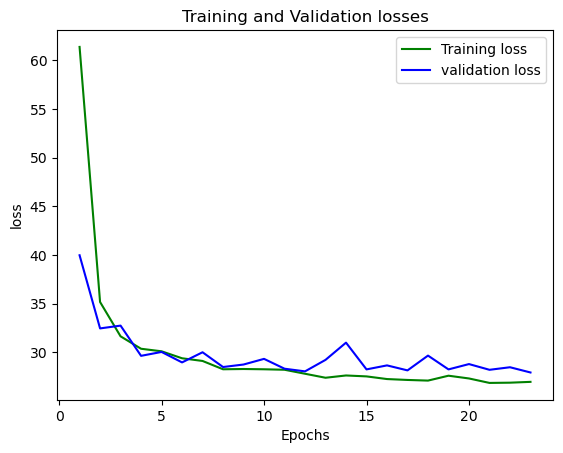

In [12]:
epoch_range = np.arange(1, history.epoch[-1]+2)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epoch_range, train_loss, 'g', label='Training loss')
plt.plot(epoch_range, val_loss, 'b', label='validation loss')
plt.title('Training and Validation losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()